In [1]:
# set the project path
%cd ~/projects/drug-pricing

/home/denhart.c/projects/drug-pricing


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

import os
import pickle
from datetime import datetime
from tqdm import tqdm
from bson.objectid import ObjectId
from collections import Counter

import pandas as pd

from src.utils import connect_to_mongo, get_nlp, ROOT_DIR, get_praw
from src.schema import Post, User

In [4]:
connect_to_mongo()

In [5]:
lockdown_dt = datetime(2020, 3, 1)
max_dt = datetime.now()
min_dt = lockdown_dt - (max_dt - lockdown_dt)

In [6]:
def get_user_month_counts() -> pd.DataFrame:
	pipeline = [
		{
			"$group": {
				"_id": { "year": {"$year": "$datetime"}, "month": {"$month": "$datetime"}, "user": "$user"},
				"num_datetimes": {"$sum": {"$cond": { "if": { "$ne": ["$datetime","true"] },"then": 1,"else": 0 }}},
				"num_spacy": {"$sum": {"$cond": { "if": { "$ne": ["$spacy","true"] },"then": 1,"else": 0 }}},
				"num_posts": {"$sum": 1},
			}
		},
        { 
            '$lookup': {
				'from': 'users',
				'localField': 'user',
				'foreignField': '_id',
				'as': 'userData'
			}
		},
	]
	month_counts = Post.objects(subreddit='opiates').limit(10).aggregate(pipeline)
	'''
	rows = [{'datetime': datetime(r['_id']['year'], r['_id']['month'], 1),
			'num_datetimes': r['num_datetimes'],
			'num_spacy': r['num_spacy'],
			'num_posts': r['num_posts']
			} for r in res if (r['_id']['year'] and r['_id']['month'])]
	df = pd.DataFrame(rows)
	return df
	'''
	res = list(month_counts)
	return res


In [7]:
res = get_user_month_counts()

In [58]:
p1 = User.objects(pk='6154445924dd76f5e6e3cc80')

In [68]:
ids = [str(r['_id']['user']) if 'user' in r['_id'] else None for r in res]

In [73]:
usernames = [User.objects(pk=_id).only('username').first().username if _id else None for _id in ids]

In [65]:
for r in res:
    print(r['_id']['user'])

5f27a5024c07ca09ea1b032a
6154445924dd76f5e6e3cc80


KeyError: 'user'

In [8]:
covid_cache_fp = '/work/akilby/drug_pricing_project/denhart_cache/covid_keyword_counts_cache_opiates_1634766740.pk'
with open(covid_cache_fp, 'rb') as f:
    covid_cache = pickle.load(f)

In [6]:
months_users_fp = '/work/akilby/drug_pricing_project/denhart_cache/opiates_month_user_counts_2021-10-14 08:08:02.963907.pk'
with open(months_users_fp, 'rb') as f:
    month_users_counts = pickle.load(f)

In [8]:
len(month_users_counts)

359409

In [11]:
def raw_user_months_to_df(user_months):
    usernames = []
    datetimes = []
    nposts = []
    for row in user_months:
        usernames.append(row[0])
        if (row[1]['_id']['year'] and row[1]['_id']['month']):
            datetimes.append(datetime(row[1]['_id']['year'], row[1]['_id']['month'], 1))
        else:
            datetimes.append(None)
        nposts.append(row[1]['num_posts'])
    
    df = pd.DataFrame({
        'username': usernames,
        'datetime': datetimes,
        'nposts': nposts
    })
    return df

In [12]:
user_month_df = raw_user_months_to_df(month_users_counts)

In [16]:
tf = datetime.now()
user_month_df.to_csv(f'/work/akilby/drug_pricing_project/denhart_cache/user_month_counts_df_{tf}', index=False)

In [9]:
keyword_to_type_map = dict(zip(keywords_by_month['keywords'].tolist(), keywords_by_month['type'].tolist()))

NameError: name 'keywords_by_month' is not defined

In [10]:
all_keywords = list(covid_cache[list(covid_cache.keys())[0]].keys())

In [11]:
sample_user = list(covid_cache.keys())[0]
sample_keyword = list(covid_cache[sample_user].keys())[0]

In [12]:
set(keyword_to_type_map.values())

NameError: name 'keyword_to_type_map' is not defined

In [13]:
all_months = list(covid_cache[sample_user][sample_keyword].keys())

In [14]:
month_keywords = []
month_months = []
month_counts = []
month_users = []
for user in tqdm(covid_cache):
    for keyword in all_keywords:
        for month in all_months:
            count = covid_cache[user][keyword][month]
            if count > 0:
                month_users.append(user)
                month_keywords.append(keyword)
                month_counts.append(count)
                month_months.append(month)

100%|██████████| 64130/64130 [06:02<00:00, 176.86it/s]


In [14]:
len(month_keywords)

1065410

In [16]:
opiates_df = pd.read_csv('cache/opiates_by_month_10_7.csv')

In [21]:
opiates_df['types'] = opiates_df.keywords.apply(lambda k: keyword_to_type_map[k] if k in keyword_to_type_map else None)

In [23]:
opiates_df.to_csv('opiates_counts_types.csv')

In [26]:
from collections import Counter

In [27]:
Counter(opiates_df['types'])

Counter({None: 658505, 'physical': 279747, 'money': 68674})

In [ ]:
set(opiates_df)

In [15]:
getsizeof((month_keywords, month_counts, month_months))

NameError: name 'getsizeof' is not defined

In [ ]:
len(month_months)

In [15]:
monthly_data = {
    'keywords': month_keywords,
    'months': month_months,
    'counts': month_counts,
    'users': month_users
}

In [28]:
len(month_months)

501

In [16]:
monthly_cache_fp = os.path.join(
    '/work/akilby/drug_pricing_project', 
    'denhart_cache', 
    'monthly_opiates_data_10_7_new.pk'
)
with open(monthly_cache_fp, 'wb') as f:
    pickle.dump(monthly_data, f)

In [8]:
with open(monthly_cache_fp, 'rb') as f:
    monthly_data = pickle.load(f)

EOFError: Ran out of input

In [34]:
monthly_data.keys()

dict_keys(['keywords', 'months', 'counts', 'users'])

In [40]:
'payment' in monthly_data['keywords']

True

In [17]:
opiates_keywords_by_month = pd.DataFrame(monthly_data)

In [28]:
'methadone' in opiates_keywords_by_month['keywords'].tolist()

True

In [19]:
opiates_keywords_by_month.head()

,keywords,months,counts,users
0,die,"(9, 2021)",2,593365
1,methadone,"(9, 2021)",2,593365
2,take,"(9, 2021)",2,593365
3,addict,"(9, 2021)",1,593365
4,hook,"(9, 2021)",1,593365


In [29]:
opiates_keywords_by_month.to_csv('/work/akilby/drug_pricing_project/denhart_cache/opiates_by_month_10_21.csv', index=False)

In [32]:
len(set(opiates_keywords_by_month['keywords']))

350

In [37]:
opiates_keywords_by_month.head()

,keywords,months,counts,users,type
0,check,"(9, 2021)",1,593365,money
1,try,"(9, 2021)",4,593365,None
2,die,"(9, 2021)",2,593365,physical
3,agree,"(9, 2021)",1,593365,None
4,fent,"(9, 2021)",2,593365,None


In [7]:
opiates_keywords_by_month = pd.read_csv('/work/akilby/drug_pricing_project/denhart_cache/opiates_by_month_10_4.csv')

In [32]:
opiates_keywords_by_month['type'] = opiates_keywords_by_month.keywords.apply(
    lambda k: keyword_to_type_map[k] if k in keyword_to_type_map else None
)

In [33]:
opiates_keywords_by_month

,keywords,months,counts,users,type
0,check,"(9, 2021)",1,593365,money
1,try,"(9, 2021)",4,593365,None
2,die,"(9, 2021)",2,593365,physical
3,agree,"(9, 2021)",1,593365,None
4,fent,"(9, 2021)",2,593365,None
...,...,...,...,...,...
1065405,sick,"(3, 2019)",1,DeadReligion,None
1065406,take,"(3, 2019)",3,DeadReligion,None
1065407,nauseous,"(3, 2019)",1,DeadReligion,None
1065408,go,"(3, 2019)",1,DeadReligion,None


In [12]:
def month_before(m) -> str:
    dt = datetime(m[1], m[0], 1)
    if ((dt.year < lockdown_dt.year) or 
        (dt.year == lockdown_dt.year and dt.month < lockdown_dt.month)):
        return 'before'
    return 'after'

In [13]:
opiates_keywords_by_month['period'] = opiates_keywords_by_month.months.apply(
    month_before
)

TypeError: an integer is required (got type str)

In [46]:
month_df = opiates_keywords_by_month.groupby(['months', 'keywords']).agg({
    'counts': 'sum', 
    'period': 'first',
    'type': 'first',
})

In [47]:
month_full_df = month_df.reset_index()

In [48]:
month_full_df['datetime'] = month_full_df.months.apply(lambda d: datetime(d[1], d[0], 1))

In [50]:
month_full_df.head()

,months,keywords,counts,period,type,datetime
0,"(1, 2019)",abandon,14,before,None,2019-01-01
1,"(1, 2019)",account,234,before,money,2019-01-01
2,"(1, 2019)",addict,1677,before,None,2019-01-01
3,"(1, 2019)",adjourn,0,before,None,2019-01-01
4,"(1, 2019)",agree,720,before,None,2019-01-01


In [91]:
addict_df = month_full_df.loc[month_full_df['keywords'] == 'addict'].sort_values('datetime')

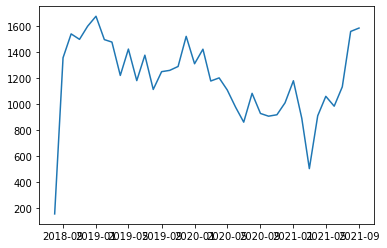

In [92]:
plt.plot(addict_df['datetime'], addict_df['counts'])

In [ ]:
month_full_df.drop('months', axis=1).to_csv('cache/keyword_month_counts_10_1.csv', index=False)

In [ ]:
with open('cache/opiates_month_counts.pk', 'rb') as f:
    subr_counts = pickle.load(f)

In [ ]:
subr_counts_dict = {datetime(r['_id']['year'], r['_id']['month'], 1): r['count']
                    for r in subr_counts
                    if r['_id']['month']}

In [ ]:
subr_counts_df = pd.DataFrame.from_dict(subr_counts_dict, orient='index').reset_index()

In [ ]:
subr_counts_df.columns = ['datetime', 'count']

In [ ]:
subr_counts_df = subr_counts_df.sort_values('datetime')

In [ ]:
subr_counts_df.to_csv('cache/opiates_subr_month_counts_10_1.csv', index=False)

In [ ]:
type_df = opiates_keywords_by_month.dropna().groupby(['type', 'period']).sum()

In [ ]:
g = sns.catplot(
    data=keyword_df, kind="bar",
    x="keywords", y="counts", hue="period",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Keywords")
g.legend.set_title("")
plt.xticks(rotation=45)
plt.savefig('figures/keyword_counts.png', bbox_inches='tight')
plt.show()

## r/opiates month counts

In [52]:
pk = pickle.load(open('cache/opiates_month_counts_2021-09-30 11:59:19.609911.pk', 'rb'))

In [68]:
ropiates_counts = []
ropiates_months = []
for r in pk:
    ropiates_counts.append(r['count'])
    if r['_id']['year']:
        ropiates_months.append(datetime(r['_id']['year'], r['_id']['month'], 1))
    else: 
        ropiates_months.append(None)

In [69]:
ropiates_month_counts_df = pd.DataFrame({
    'counts': ropiates_counts,
    'months': ropiates_months,
})

In [73]:
ropiates_month_counts_df = ropiates_month_counts_df.sort_values('months')

In [76]:
ropiates_month_counts_df.to_csv('/work/akilby/drug_pricing_project/denhart_cache/ropiates_counts_10_4.csv')

In [77]:
import matplotlib.pyplot as plt

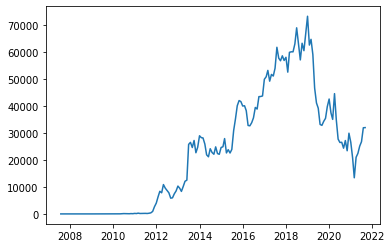

In [78]:
plt.plot(ropiates_month_counts_df.months, ropiates_month_counts_df.counts)

In [79]:
psaw_pk = pickle.load(open('cache/psaw_comm_month_counts_2021-09-29 06:45:51.903761.pk', 'rb'))

In [81]:
psaw_months = [datetime(r[1], r[0], 1) for r in psaw_pk.keys()]
psaw_counts = list(psaw_pk.values())

In [85]:
psaw_df = pd.DataFrame({
    'months': psaw_months,
    'counts': psaw_counts,
}).sort_values('months')

In [88]:
psaw_df.to_csv('/work/akilby/drug_pricing_project/denhart_cache/psaw_counts_10_4.csv')

(array([17775., 17897., 18017., 18140., 18262., 18383., 18506., 18628.,
        18748., 18871.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

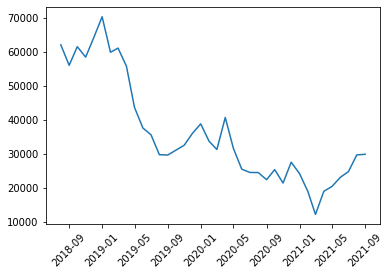

In [87]:
plt.plot(psaw_df['months'], psaw_df['counts'])
plt.xticks(rotation=45)

## Map Viz

In [11]:
users_preds = pickle.load(open('results/user-predictions-1623287814.pk', 'rb'))